In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from utilities import retrieve_data
import calendar

ERA_VERSION = 'ERA5'  # One day this will change to ERA6

# ====================
# To get a CDS API key, sign up at https://cds.climate.copernicus.eu/
# It is free and easy! After registering, copy your "Personal Access Token here"
# ====================
KEY = '############################'
KEY = '6cc2b53b-e3c0-42fd-b7ad-db64aeeb5298'
KEY = '8f3ee43a-fa64-4eb9-a403-6567171bb625'

# ====================
# Change these to plot different locations. You can see the currently used ones in the ERA Explorer URL
# ====================
lat = 50.86  # Default latitude
lng = 4.35  # Default longitude

# ====================
# These can be changed to get different data; leave them for now
# ====================
variable = "2m_temperature"
date_range = ["1991-01-01", "2020-12-31"]

# ====================
# Get the data. This will download a NetCDF file
# ====================
data_file = retrieve_data(KEY, variable, date_range, lat, lng)

# ====================
# To calculate relative humidity we need dewpoint temperature as well
# ====================
variable2 = "2m_dewpoint_temperature"
data_file2 = retrieve_data(KEY, variable2, date_range, lat, lng)


2024-12-10 15:28:45,234 INFO [2024-07-18T00:00:00] Remember that you need to have an ECMWF account to use CDS-Beta. **Your existing CDS credentials will not work in CDS-Beta!**
2024-12-10 15:28:45,235 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2024-12-10 15:28:45,235 WARNING [2024-06-16T00:00:00] Check our [informative page](https://confluence.ecmwf.int/x/uINmFw) to best prepare yourself to use CDS-Beta.
2024-12-10 15:28:45,235 WARNING [2024-06-16T00:00:00] **BETA version** of the new CDS. Your [feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is very useful for us. **Please notice** that access to the system might suffer some disruptions due to evolving updates.


{'variable': ['2m_temperature'], 'date': ['1991-01-01/2020-12-31'], 'location': {'longitude': 4.35, 'latitude': 50.86}, 'data_format': 'netcdf'}
2m_temperature_1991-01-01_2020-12-31_50.86_4.35.nc


2024-12-10 15:28:45,363 INFO Request ID is a242f56e-07c0-4889-94bc-a66d6c7109bf
2024-12-10 15:28:45,409 INFO status has been updated to accepted
2024-12-10 15:28:46,460 INFO status has been updated to running
2024-12-10 15:28:48,019 INFO status has been updated to successful
2024-12-10 15:28:48,861 INFO [2024-07-18T00:00:00] Remember that you need to have an ECMWF account to use CDS-Beta. **Your existing CDS credentials will not work in CDS-Beta!**
2024-12-10 15:28:48,862 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2024-12-10 15:28:48,862 WARNING [2024-06-16T00:00:00] Check our [informative page](https://confluence.ecmwf.int/x/uINmFw) to best prepare yourself to use CDS-Beta.
2024-12-10 15:28:48,862 WARNING [2024-06-16T00:00:00] **BETA version** of the new C

Retrieving data in to:  2m_temperature_1991-01-01_2020-12-31_50.86_4.35.nc
{'variable': ['2m_dewpoint_temperature'], 'date': ['1991-01-01/2020-12-31'], 'location': {'longitude': 4.35, 'latitude': 50.86}, 'data_format': 'netcdf'}
2m_dewpoint_temperature_1991-01-01_2020-12-31_50.86_4.35.nc


2024-12-10 15:28:49,044 INFO Request ID is cb409d89-6d76-48aa-a122-5007e5a9084c
2024-12-10 15:28:49,095 INFO status has been updated to accepted
2024-12-10 15:28:50,148 INFO status has been updated to running
2024-12-10 15:28:51,700 INFO status has been updated to successful
                                                                                        

Retrieving data in to:  2m_dewpoint_temperature_1991-01-01_2020-12-31_50.86_4.35.nc


In [3]:
# Define a function to calculate relative humidity
def calculate_rh(data_d2m_pt, data_t2m_pt, method):
    """
    Calculate relative humidity using specified method.
    Parameters:
    data_d2m_pt (numpy.ndarray): Dew point temperature data in Kelvin.
    data_t2m_pt (numpy.ndarray): Air temperature data in Kelvin.
    method (str): Method to use for calculation. Options are "August-Roche-Magnus" or "Clausius-Clapeyron".
    Returns:
    numpy.ndarray: Calculated relative humidity as a percentage.
    Raises:
    ValueError: If an invalid method is specified.
    """

    # Convert temperatures from Kelvin to Celsius
    data_t2m_pt -= 273.15
    data_d2m_pt -= 273.15

    if (method == "August-Roche-Magnus"):
        # Values are calculated using the August-Roche-Magnus approximation.
        numerator = np.exp((17.625 * (data_d2m_pt)) / (243.04 + (data_d2m_pt)))
        denominator = np.exp((17.625 * (data_t2m_pt)) / (243.04 + (data_t2m_pt)))
        rh = (numerator * 100)/denominator
    elif (method == "Clausius-Clapeyron"):
        # Values are calculated using the Clausius-Clapeyron relation.
        numerator = 6.11 * 10 ^ (7.5 * ((data_d2m_pt)/(237.7 + data_d2m_pt)))
        denominator = 6.11 * 10 ^ (7.5 * ((data_t2m_pt)/(237.7 + data_t2m_pt)))
        rh = (numerator * 100)/denominator
    else:
        raise ValueError("Invalid method specified")

    return rh

# Make a function to compute the humidity monthly climatology
def humidityMonthlyClimatology():
    """
    Calculate the monthly climatology of relative humidity.
    This function reads temperature and dew point temperature data from NetCDF files,
    calculates the relative humidity using the specified method, and then computes
    the monthly climatology of daily minimum and maximum relative humidity.
    Returns:
        pandas.DataFrame: A DataFrame containing the monthly climatological averages
                          for daily minimum and maximum relative humidity.
    """
 
    data_t2m_pt = xr.open_dataset(data_file).t2m
    data_d2m_pt = xr.open_dataset(data_file2).d2m

    # Specify the method for calculating relative humidity
    method = "August-Roche-Magnus"

    # Calculate relative humidity
    data_rh_pt = calculate_rh(data_d2m_pt, data_t2m_pt, method)

    # Convert the time coordinate to a pandas datetime index
    time_index = pd.to_datetime(data_rh_pt.valid_time.values)
    
    # Create a DataFrame for easier manipulation
    df = pd.DataFrame(data_rh_pt.values, index=time_index, columns=['rh'])
    
    # Resample to find daily minimum and maximum
    daily_min = df.resample('D').min()
    daily_max = df.resample('D').max()
    
    # Combine the daily min and max into a single DataFrame
    daily_stats = pd.DataFrame({
        'daily_min': daily_min['rh'],
        'daily_max': daily_max['rh']
    })

    # Extract the month from DateTimeIndex
    daily_stats['month'] = daily_stats.index.month
    
    # Group by month and calculate climatological averages for daily min and max
    grouped_by_month = daily_stats.groupby('month')
    monthly_climatology = grouped_by_month.mean()
    
    return monthly_climatology
    
# Call our function
clim = humidityMonthlyClimatology()

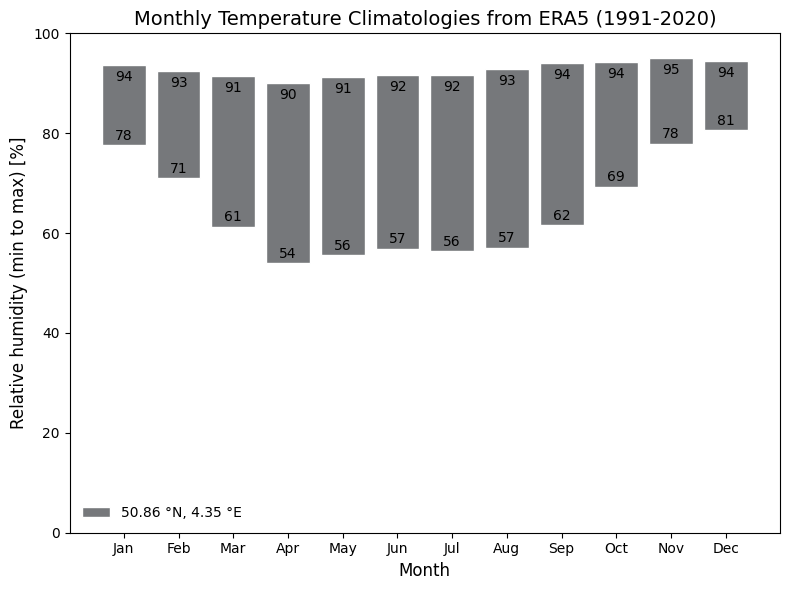

In [4]:
# Make the plot
lw = 2
marker = 'o'
markersize = 4

latSuffix = 'N' if lat > 0 else 'S'
lngSuffix = 'E' if lng > 0 else 'W'

plt.figure(figsize=(8, 6))

# Plot the data as a bar chart
bars = plt.bar(
    clim.index,
    clim['daily_max'] - clim['daily_min'],
    bottom=clim['daily_min'],
    width=0.8,
    color='#76787B',
    edgecolor='white',
    label=f'{abs(lat):.2f} °{latSuffix:s}, {abs(lng):.2f} °{lngSuffix:s}'
)

# Add labels to each bar
for index, bar in enumerate(bars):
    daily_min = clim['daily_min'].iloc[index]
    daily_max = clim['daily_max'].iloc[index]
    
    # Compute positions for the text
    x = bar.get_x() + bar.get_width() / 2  # Center of the bar
    
    # Add the labels (daily_min and daily_max) on two lines
    plt.text(
        x,  # X position
        bar.get_y() + 0.5,
        f'{daily_min:.0f}',  # Label text with new line
        ha='center',  # Center horizontally
        va='bottom',  # Align below the top of the bar
        fontsize=10,  # Font size
        color='black'  # Text color
    )

     # Add the labels (daily_min and daily_max) on two lines
    plt.text(
        x,  # X position
        bar.get_height() + bar.get_y() - 1,
        f'{daily_max:.0f}',  # Label text with new line
        ha='center',  # Center horizontally
        va='top',  # Align below the top of the bar
        fontsize=10,  # Font size
        color='black'  # Text color
    )


# Add legend
plt.legend(framealpha=0)

# Customize x and y axis labels
plt.xlabel('Month', fontsize=12)
plt.ylabel('Relative humidity (min to max) [%]', fontsize=12)

plt.ylim(0, 100)  # Set y-axis limits

# Set x-ticks to month labels
plt.xticks(ticks=clim.index, labels=[calendar.month_abbr[i] for i in clim.index])

# Add title with custom font
plt.title(f'Monthly Temperature Climatologies from {ERA_VERSION} ({date_range[0][:4]}-{date_range[1][:4]})', fontsize=14)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()